# Experiment 2 Preliminary Experiment

### Imports

In [22]:
import random

import instancelib as il
from instancelib.machinelearning.sklearn import SkLearnClassifier
from instancelib.typehints.typevars import KT, LT
from instancelib.utils.func import list_unzip

from typing import Any, FrozenSet, Sequence, Tuple

import pandas as pd
import numpy as np

from instancelib.analysis.base import classifier_performance
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sbert import PretrainedSentenceBERTVectorizer
from stratified import stratified_train_test
from synthesizer import PreSynthesized

from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_auc_score, fbeta_score


from matplotlib import pyplot as plt

In [2]:
random.seed(10)

### Define functions

In [15]:
def sklearn_truth_pred(model: SkLearnClassifier[Any, KT, Any, Any, LT],
                       predictions: Sequence[Tuple[KT, FrozenSet[LT]]],
                       truth: il.LabelProvider[KT, LT]) -> Tuple[np.ndarray, np.ndarray]:
    '''Return true and predicted labels from test set'''
    keys, preds = list_unzip(predictions)
    truths = [truth.get_labels(key) for key in keys]
    y_pred = model.encoder.encode_batch(preds)
    y_true = model.encoder.encode_batch(truths)
    return y_true, y_pred

### Load data

In [3]:
df = pd.read_csv("../../data/active_learning_data_to_test_imbalanced_with_identifiers.csv")
tweet_env = il.pandas_to_env_with_id(df, "identifier", "clean_post", "set")

### Preparation

*Vectorize data with RobBERT*

In [5]:
sbert_vec = il.TextInstanceVectorizer(PretrainedSentenceBERTVectorizer("pdelobelle/robbert-v2-dutch-base"))

In [6]:
il.vectorize(sbert_vec, tweet_env, fit = False, chunk_size=20000)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/216 [00:00<?, ?it/s]

*Split data in train and testset*

In [7]:
# Create a train set of 70 %. 
# The remainder will be used as evaluation
train, test = stratified_train_test(tweet_env, tweet_env.dataset, tweet_env.labels, 0.70)

In [8]:
print(len(train), len(test))

32830 14070


*Initialize all classifiers to try*

In [14]:
logreg = LogisticRegression(max_iter=1000)
svm = SVC(kernel="linear", probability=True)
knn = KNeighborsClassifier(3)
nb = GaussianNB()
dt = DecisionTreeClassifier(max_depth=5)
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
lgbm = LGBMClassifier()
nn = MLPClassifier(alpha=1, max_iter=1000)
model_logreg = il.SkLearnVectorClassifier.build(logreg, tweet_env)
model_svm = il.SkLearnVectorClassifier.build(svm, tweet_env)
model_knn = il.SkLearnVectorClassifier.build(knn, tweet_env)
model_nb = il.SkLearnVectorClassifier.build(nb, tweet_env)
model_dt = il.SkLearnVectorClassifier.build(dt, tweet_env)
model_rf = il.SkLearnVectorClassifier.build(rf, tweet_env)
model_lgbm = il.SkLearnVectorClassifier.build(lgbm, tweet_env)
model_nn = il.SkLearnVectorClassifier.build(nn, tweet_env)

In [ ]:
models = [model_logreg, model_svm, model_knn, model_nb, model_dt, model_rf, model_lgbm, model_nn]

### Compare all classifiers

In [16]:
all_affair_f1 = []
all_affair_f2 = []
all_affair_r = []
all_affair_p = []
all_affair_acc = []

all_covid_f1 = []
all_covid_f2 = []
all_covid_r = []
all_covid_p = []
all_covid_acc = []

all_roc_auc_scores = []
all_mcc_scores = []

all_y_trues = []
all_y_preds = []

for model in models:
#     print(str(model))
    model.fit_provider(train, tweet_env.labels)
    performance = classifier_performance(model, test, tweet_env.labels)
    
    all_affair_f1.append(performance['affair'].f1)
    all_affair_f2.append(performance['affair'].f_beta(2))
    all_affair_r.append(performance['affair'].recall)
    all_affair_p.append(performance['affair'].precision)
    all_affair_acc.append(performance['affair'].accuracy)
    
    all_covid_f1.append(performance['covid'].f1)
    all_covid_f2.append(performance['covid'].f_beta(2))
    all_covid_r.append(performance['covid'].recall)
    all_covid_p.append(performance['covid'].precision)
    all_covid_acc.append(performance['covid'].accuracy)
    
    predictions = model.predict(test)
    y_true, y_pred = sklearn_truth_pred(model, predictions, tweet_env.labels)
    all_y_trues.append(y_true)
    all_y_preds.append(y_pred)
    
    print(confusion_matrix(y_true, y_pred))
    all_roc_auc_scores.append(roc_auc_score(y_true, y_pred))
    all_mcc_scores.append(matthews_corrcoef(y_true, y_pred))

[[13620    30]
 [  210   210]]
[[13638    12]
 [  215   205]]
[[13629    21]
 [  266   154]]
[[12462  1188]
 [  140   280]]
[[13594    56]
 [  336    84]]
[[13650     0]
 [  420     0]]


C:\Users\s153832\Anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[[13640    10]
 [  267   153]]
[[13647     3]
 [  298   122]]


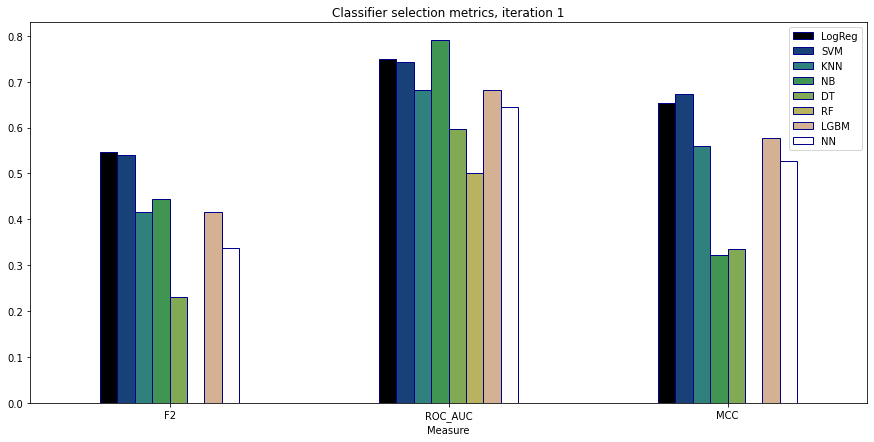

In [54]:
measures_to_decide = ['F2', 'AUC', 'MCC', 'Precision', 'Recall']
values_to_plot = list(zip(all_covid_f2, all_roc_auc_scores, all_mcc_scores, all_covid_p, all_covid_r))

df_to_plot = pd.DataFrame({'Metric':measures_to_decide, 'LogReg':list(values_to_plot[0]), 'SVM':list(values_to_plot[1]), 'KNN':list(values_to_plot[2]), 'NB':list(values_to_plot[3]), 'DT':list(values_to_plot[4]), 'RF':list(values_to_plot[5]), 'LGBM':list(values_to_plot[6]), 'NN':list(values_to_plot[7])})
ax = df_to_plot.plot.bar(x='Metric', y=['LogReg', 'SVM', 'KNN', 'NB', 'DT', 'RF', 'LGBM', 'NN'], title='Classifier selection metrics', figsize=(15, 7), rot=0, colormap='gist_earth', edgecolor='darkblue')
ax.figure.savefig('all_classifiers.png')

LogReg and SVM perform best, lets do hyperparameter search

### Hyperparameter search

*LogReg parameter search*

In [40]:
penalty_values =['l2', 'none']
c_values = [0.1, 1, 10]
class_weight_values = [None, 'balanced']

In [42]:
logreg_parameters = []
logreg_affair_f1 = []
logreg_affair_f2 = []
logreg_affair_r = []
logreg_affair_p = []
logreg_affair_acc = []

logreg_covid_f1 = []
logreg_covid_f2 = []
logreg_covid_r = []
logreg_covid_p = []
logreg_covid_acc = []

logreg_roc_auc_scores = []
logreg_mcc_scores = []

logreg_y_trues = []
logreg_y_preds = []
for class_weight in class_weight_values:
    for penalty in penalty_values:
        for c in c_values:
            logreg_para = LogisticRegression(penalty=penalty, C=c, class_weight=class_weight, max_iter=5000)
            model_logreg_para = il.SkLearnVectorClassifier.build(logreg_para, tweet_env)
            model_logreg_para.fit_provider(train, tweet_env.labels)
            performance_para = classifier_performance(model_logreg_para, test, tweet_env.labels)
            
            print(str(class_weight) + str(c) + str(penalty))
            logreg_parameters.append(str(class_weight) + str(c) + str(penalty))

            logreg_affair_f1.append(performance_para['affair'].f1)
            logreg_affair_f2.append(performance_para['affair'].f_beta(2))
            logreg_affair_r.append(performance_para['affair'].recall)
            logreg_affair_p.append(performance_para['affair'].precision)
            logreg_affair_acc.append(performance_para['affair'].accuracy)
    
            logreg_covid_f1.append(performance_para['covid'].f1)
            logreg_covid_f2.append(performance_para['covid'].f_beta(2))
            logreg_covid_r.append(performance_para['covid'].recall)
            logreg_covid_p.append(performance_para['covid'].precision)
            logreg_covid_acc.append(performance_para['covid'].accuracy)
            
            predictions = model_logreg_para.predict(test)
            y_true, y_pred = sklearn_truth_pred(model_logreg_para, predictions, tweet_env.labels)
            logreg_y_trues.append(y_true)
            logreg_y_preds.append(y_pred)
    
            print(confusion_matrix(y_true, y_pred))
            logreg_roc_auc_scores.append(roc_auc_score(y_true, y_pred))
            logreg_mcc_scores.append(matthews_corrcoef(y_true, y_pred))

None0.1l2
[[13638    12]
 [  240   180]]
None1l2
[[13620    30]
 [  210   210]]
None10l2
[[13578    72]
 [  202   218]]


C:\Users\s153832\Anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


None0.1none
[[13548   102]
 [  198   222]]
None1none
[[13548   102]
 [  198   222]]


C:\Users\s153832\Anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


None10none
[[13548   102]
 [  198   222]]
balanced0.1l2
[[12418  1232]
 [   74   346]]
balanced1l2
[[12588  1062]
 [   92   328]]
balanced10l2
[[12669   981]
 [  104   316]]


C:\Users\s153832\Anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


balanced0.1none
[[12692   958]
 [  107   313]]
balanced1none
[[12692   958]
 [  107   313]]


C:\Users\s153832\Anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


balanced10none
[[12692   958]
 [  107   313]]


In [44]:
print(logreg_parameters) #if penalty is none, the C parameter will be ignored, so 3,4,5 are the same model and 10, 11, 12 as well
# so we do not need to plot all of those
logreg_parameters_to_plot = ['None0.1l2',
 'None1l2',
 'None10l2',
 'None0.1none',
 'balanced0.1l2',
 'balanced1l2',
 'balanced10l2',
 'balanced0.1none',]

['None0.1l2', 'None1l2', 'None10l2', 'None0.1none', 'None1none', 'None10none', 'balanced0.1l2', 'balanced1l2', 'balanced10l2', 'balanced0.1none', 'balanced1none', 'balanced10none']


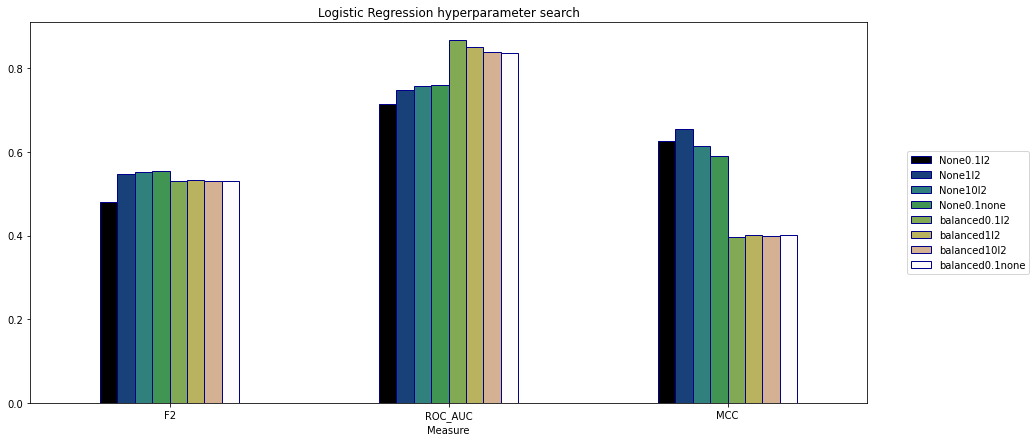

In [46]:
logreg_values_to_plot = list(zip(logreg_covid_f2, logreg_roc_auc_scores, logreg_mcc_scores, logreg_covid_p, logreg_covid_r))

logreg_df_to_plot = pd.DataFrame({'Metric':measures_to_decide})
for i in range(len(logreg_values_to_plot)):
    logreg_df_to_plot[logreg_parameters[i]] = logreg_values_to_plot[i]
ax = logreg_df_to_plot.plot.bar(x='Metric', y=logreg_parameters_to_plot, title='Logistic Regression hyperparameter search', figsize=(15, 7), rot=0, colormap='gist_earth', edgecolor='darkblue')
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

ax.figure.savefig('logreg_parameter_search.png')

None10l2 wins for LogReg

*SVM parameter search*

In [47]:
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
c_values = [0.1, 1, 10]
class_weight_values = [None, 'balanced']

In [48]:
svm_parameters = []
svm_affair_f1 = []
svm_affair_f2 = []
svm_affair_r = []
svm_affair_p = []
svm_affair_acc = []

svm_covid_f1 = []
svm_covid_f2 = []
svm_covid_r = []
svm_covid_p = []
svm_covid_acc = []

svm_roc_auc_scores = []
svm_mcc_scores = []

svm_y_trues = []
svm_y_preds = []
for class_weight in class_weight_values:
    for c in c_values:
        for kernel in kernel_values:
            svm_para = svm = SVC(kernel=kernel, C=c, class_weight=class_weight, probability=True)
            model_svm_para = il.SkLearnVectorClassifier.build(svm_para, tweet_env)
            model_svm_para.fit_provider(train, tweet_env.labels)
            performance_para = classifier_performance(model_svm_para, test, tweet_env.labels)
            
            print(str(class_weight) + str(c) + str(kernel))
            svm_parameters.append(str(class_weight) + str(c) + str(kernel))

            svm_affair_f1.append(performance_para['affair'].f1)
            svm_affair_f2.append(performance_para['affair'].f_beta(2))
            svm_affair_r.append(performance_para['affair'].recall)
            svm_affair_p.append(performance_para['affair'].precision)
            svm_affair_acc.append(performance_para['affair'].accuracy)
    
            svm_covid_f1.append(performance_para['covid'].f1)
            svm_covid_f2.append(performance_para['covid'].f_beta(2))
            svm_covid_r.append(performance_para['covid'].recall)
            svm_covid_p.append(performance_para['covid'].precision)
            svm_covid_acc.append(performance_para['covid'].accuracy)
            
            predictions = model_svm_para.predict(test)
            y_true, y_pred = sklearn_truth_pred(model_svm_para, predictions, tweet_env.labels)
            svm_y_trues.append(y_true)
            svm_y_preds.append(y_pred)
    
            print(confusion_matrix(y_true, y_pred))
            svm_roc_auc_scores.append(roc_auc_score(y_true, y_pred))
            svm_mcc_scores.append(matthews_corrcoef(y_true, y_pred))

None0.1linear
[[13647     3]
 [  227   193]]
None0.1poly
[[13650     0]
 [  416     4]]
None0.1rbf
[[13650     0]
 [  420     0]]


C:\Users\s153832\Anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


None0.1sigmoid
[[13650     0]
 [  420     0]]


C:\Users\s153832\Anaconda3\envs\thesis_gpu\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


None1linear
[[13638    12]
 [  215   205]]
None1poly
[[13647     3]
 [  262   158]]
None1rbf
[[13647     3]
 [  275   145]]
None1sigmoid
[[13650     0]
 [  378    42]]
None10linear
[[13606    44]
 [  206   214]]
None10poly
[[13647     3]
 [  225   195]]
None10rbf
[[13647     3]
 [  227   193]]
None10sigmoid
[[13646     4]
 [  250   170]]
balanced0.1linear
[[12374  1276]
 [   83   337]]
balanced0.1poly
[[12055  1595]
 [   74   346]]
balanced0.1rbf
[[12049  1601]
 [   78   342]]
balanced0.1sigmoid
[[12484  1166]
 [  113   307]]
balanced1linear
[[12456  1194]
 [  104   316]]
balanced1poly
[[12305  1345]
 [   66   354]]
balanced1rbf
[[12285  1365]
 [   68   352]]
balanced1sigmoid
[[12067  1583]
 [   70   350]]
balanced10linear
[[12589  1061]
 [  112   308]]
balanced10poly
[[12910   740]
 [  107   313]]
balanced10rbf
[[12790   860]
 [   98   322]]
balanced10sigmoid
[[11983  1667]
 [   68   352]]


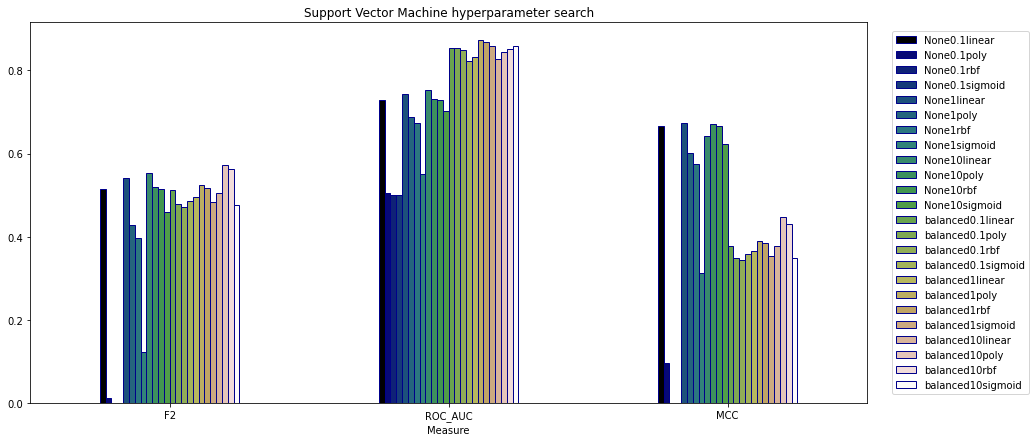

In [50]:
svm_values_to_plot = list(zip(svm_covid_f2, svm_roc_auc_scores, svm_mcc_scores, svm_covid_p, svm_covid_r))

svm_df_to_plot = pd.DataFrame({'Metric':measures_to_decide})
for i in range(len(svm_values_to_plot)):
    svm_df_to_plot[svm_parameters[i]] = svm_values_to_plot[i]
ax = svm_df_to_plot.plot.bar(x='Metric', y=svm_parameters, title='Support Vector Machine hyperparameter search', figsize=(15, 7), rot=0, colormap='gist_earth', edgecolor='darkblue')
ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))

ax.figure.savefig('svm_parameter_search.png')

None1linear wins

### Final comparison

In [73]:
final_comp = pd.DataFrame({'Metric':measures_to_decide})
final_comp['LogReg'] = logreg_df_to_plot['None1l2']
final_comp['SVM'] = logreg_df_to_plot['None1linear']

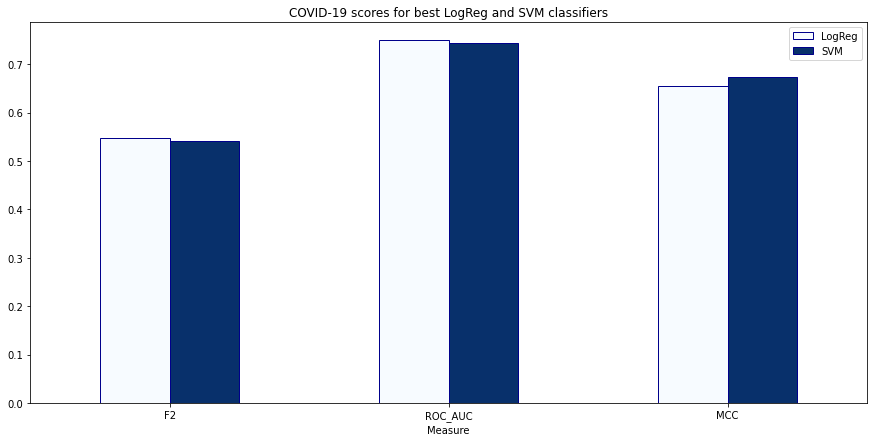

In [74]:
ax = final_comp.plot.bar(x='Metric', y=['LogReg', 'SVM'], title='COVID-19 scores for best LogReg and SVM classifiers', figsize=(15, 7), rot=0, colormap='Blues', edgecolor='darkblue')
ax.figure.savefig('logreg_vs_svms.png')